# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [42]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum, isnan, to_date, to_timestamp, from_unixtime, count

import pyspark.sql.functions as F

from pyspark.sql.types import LongType, TimestampType
from pyspark.sql.functions import substring, from_unixtime

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt

import findspark
findspark.init()

In [2]:
spark = SparkSession \
    .builder \
    .appName("Wrangling Data") \
    .getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [3]:
path = "mini_sparkify_event_data.json"
df = spark.read.json(path)
df_original = df

In [4]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [5]:
# Easier visual exploration as Pandas data frame
df.limit(5).toPandas()

# Questions to explore:
# sessionId unique across users? (can two users have the same sessionId?)
# what is the column "method"

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1538331630000,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1538173362000,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [6]:
# Which pages do users interact with?
# df.select("page").dropDuplicates().sort("page").show()
# df.select("auth").dropDuplicates().sort("auth").show()

df.groupBy("page").count().sort("count", ascending=False).toPandas()

,page,count
0,NextSong,228108
1,Home,14457
2,Thumbs Up,12551
3,Add to Playlist,6526
4,Add Friend,4277
5,Roll Advert,3933
6,Login,3241
7,Logout,3226
8,Thumbs Down,2546
9,Downgrade,2055


In [7]:
# https://stackoverflow.com/questions/52319958/pyspark-select-the-distinct-values-from-each-column
import pyspark.sql.functions as f
# df.select(*[f.collect_set(c).alias(c) for c in df.columns]).toPandas()

In [8]:
# Distinct values per column
# https://stackoverflow.com/questions/40888946/spark-dataframe-count-distinct-values-of-every-column
from pyspark.sql.functions import col, countDistinct

distinct_value_count = df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).toPandas()
distinct_value_count

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,17655,4,189,2,1322,173,14865,2,114,2,22,225,2354,58480,3,277447,56,226


In [9]:
distinct_value_count > 2

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,True,True,True,False,True,True,True,False,True,False,True,True,True,True,True,True,True,True


In [10]:
# https://stackoverflow.com/questions/48229043/python-pyspark-count-null-empty-and-nan
df.filter((df["ts"] == "") | df["ts"].isNull() | isnan(df["ts"])).count()

0

## Cleanup & Prep of Timestamp and Date

In [11]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)
# get_date = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). date)


In [12]:
df = df_original
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [13]:
# Remove milliseconds (last 3 digits) from ts to enable conversion to datetime
df = df.withColumn("ts_no_ms", substring(df.ts, 0, 10))
# df = df.withColumn("ts_no_ms", df.ts_no_ms.cast(TimestampType()))
# df = df.withColumn("ts_unix", from_unixtime(df.ts))
df = df.withColumn("ts_str", F.from_unixtime(df.ts_no_ms))
df = df.withColumn("ts_tsType", df.ts_str.cast(TimestampType()))

df = df.withColumn("weekday", F.weekday(df.ts_tsType))
df = df.withColumn("hour", F.hour(df.ts_tsType))
df = df.withColumn("year", F.year(df.ts_tsType))
df = df.withColumn("weekNum", F.weekofyear(df.ts_tsType))



# df.printSchema()
df.head(5)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_no_ms='1538352117', ts_str='2018-10-01 02:01:57', ts_tsType=datetime.datetime(2018, 10, 1, 2, 1, 57), weekday=0, hour=2, year=2018, weekNum=40),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9', ts_no_ms='

In [14]:
songs_in_hour = df.groupby("hour").count().sort("hour").toPandas()
df.filter(df.page == "NextSong").groupby("hour").count().sort("hour").toPandas()

,hour,count
0,0,9908
1,1,9327
2,2,8895
3,3,8339
4,4,8359
5,5,8229
6,6,7979
7,7,8114
8,8,8119
9,9,8225


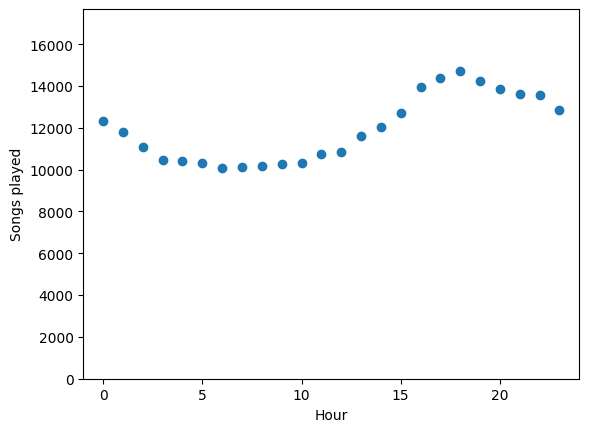

In [15]:
plt.scatter(songs_in_hour["hour"], songs_in_hour["count"])
plt.xlim(-1, 24);
plt.ylim(0, 1.2 * max(songs_in_hour["count"]))
plt.xlabel("Hour")
plt.ylabel("Songs played");

In [16]:
def groupby_plot(df, x_col:str, page_filter:str, x_label:str, y_label:str):
    """Aggregate data and create scatterplot to visualize trends in the data."""
    # df_grouped = df.groupby(x_col).count().sort(x_col).toPandas()
    df_grouped = df.filter(df.page == page_filter).groupby(x_col).count().sort(x_col).toPandas()
    plt.scatter(df_grouped[x_col], df_grouped["count"])
    plt.xlim(-1, max(df_grouped[x_col])+1);
    plt.ylim(0, 1.2 * max(df_grouped["count"]))
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.show
    return None

In [17]:
df.agg(*(countDistinct(col(c)).alias(c) for c in df.columns)).toPandas()

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,...,ts,userAgent,userId,ts_no_ms,ts_str,ts_tsType,weekday,hour,year,weekNum
0,17655,4,189,2,1322,173,14865,2,114,2,...,277447,56,226,277447,277447,277447,7,24,1,10


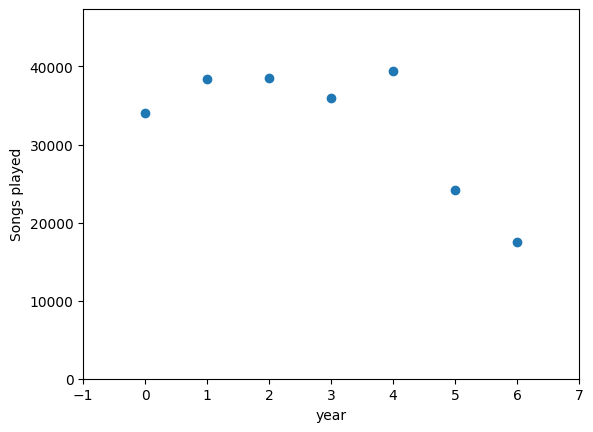

In [18]:
# groupby_plot(df, "hour", "NextSong", "Hour", "Songs played")

# groupby_plot(df, "hour", "Home", "Hour", "Songs played")

groupby_plot(df, "weekday", "NextSong", "year", "Songs played")

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [20]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- ts_no_ms: string (nullable = true)
 |-- ts_str: string (nullable = true)
 |-- ts_tsType: timestamp (nullable = true)
 |-- weekday: integer (nullable = true)
 |-- hour: integer (nullable = true)
 |-- year: integer (nullable = true)
 |-- weekNum: integer (nullable = true)



In [48]:
# Number of unique users in this subset of data
df.agg(countDistinct("userID")).collect()[0][0]

226

In [45]:
# Number of subscription cancellations (churn)
df.where(df.page=="Cancellation Confirmation").agg(count("userID")).collect()

df.where(df.page=="Cancellation Confirmation").count()

52

In [58]:
# Are all of these unique cancellations or did some users resubscribe and cancel again?
df.where(df.page=="Cancellation Confirmation").groupBy("userId").count().sort("count", ascending=False).head()
# > No, all cancellations are from unique users

Row(userId='18', count=1)

### Add churn flag and other potentially useful features

In [139]:
df = df.withColumn("churnFlag", F.when(df.page=="Cancellation Confirmation", 1).otherwise(0))
df.where(df.churnFlag==1).show(5)

+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+
|artist|     auth|firstName|gender|itemInSession|lastName|length|level|            location|method|                page| registration|sessionId|song|status|           ts|           userAgent|userId|  ts_no_ms|             ts_str|          ts_tsType|weekday|hour|year|weekNum|churnFlag|window_test|
+------+---------+---------+------+-------------+--------+------+-----+--------------------+------+--------------------+-------------+---------+----+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+
|  NULL|Cancelled|  Rodrigo|     M|           73|   Carey|  NULL| paid|New York-Newark-J...|   GET|Cancell

### Create column that flags all churned users for each interaction

In [159]:
# from pyspark.sql.window import Window

# window_userId = Window.partitionBy("userId").orderBy("ts")

# df = df.withColumn("window_test", count("userId").over(window_userId))
# df.show()

In [161]:
df.createOrReplaceTempView("user_logs")

# Issue, the distinct userId also selects rows where the flag is not present

df_sql = spark.sql('''
    SELECT *, IF(flag = 1, 1, 0) AS userChurned
    FROM user_logs
    LEFT JOIN (
        SELECT DISTINCT userId AS uid, 1 AS flag
        FROM user_logs
        WHERE churnFlag = 1
        ) AS churned_users
    ON user_logs.userId = churned_users.uid
    '''
)

df_sql = df_sql.drop(*["uid", "flag"])

df_sql.show()

+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+-----------+
|              artist|     auth|firstName|gender|itemInSession| lastName|   length|level|            location|method|       page| registration|sessionId|                song|status|           ts|           userAgent|userId|  ts_no_ms|             ts_str|          ts_tsType|weekday|hour|year|weekNum|churnFlag|window_test|userChurned|
+--------------------+---------+---------+------+-------------+---------+---------+-----+--------------------+------+-----------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+--------

In [167]:
df_sql.filter((df_sql.userChurned == 1) & (df_sql.page != "Cancellation Confirmation")).show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+-----------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|     page| registration|sessionId|                song|status|           ts|           userAgent|userId|  ts_no_ms|             ts_str|          ts_tsType|weekday|hour|year|weekNum|churnFlag|window_test|userChurned|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+-----------+-----------+
|   

In [ ]:
# How to flg actions before churn per user?
# Groupby / window by user and flag where the timestamp is before the churnFlag
# df = df.withColumn("beforeChurn")



# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [111]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline


In [89]:
# String indexer for visited page
str_indexer = StringIndexer(inputCol="page", outputCol="page_numeric")

model = str_indexer.fit(df)

df_transformed = model.transform(df)

str_ohe = OneHotEncoder(inputCol="page_numeric", outputCol="page_vec")
model2 = str_ohe.fit(df_transformed)
df_transformed = model2.transform(df_transformed)

# df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

df_transformed.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+------------+--------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|  ts_no_ms|             ts_str|          ts_tsType|weekday|hour|year|weekNum|churnFlag|page_numeric|      page_vec|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+---

In [81]:
# The approach of indexing and transforming several columns at once was taken from here: 
# https://stackoverflow.com/questions/36942233/apply-stringindexer-to-several-columns-in-a-pyspark-dataframe

indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["page"]]

pipeline = Pipeline(stages=indexers)

df_transformed = pipeline.fit(df).transform(df)

df_transformed.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', ts_no_ms='1538352117', ts_str='2018-10-01 02:01:57', ts_tsType=datetime.datetime(2018, 10, 1, 2, 1, 57), weekday=0, hour=2, year=2018, weekNum=40, churnFlag=0, page_index=0.0)

In [101]:
# Test same approach as above for multiple columns and then indexing + vectorizing
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df) for column in ["page", "gender"]]

vectorizers = [OneHotEncoder(inputCol=column, outputCol=column+"_ohe").fit(df) for column in ["page_index", "gender_index"]]


pipeline = Pipeline(stages=indexers)

df_transformed = pipeline.fit(df).transform(df)

df_transformed.show()

IllegalArgumentException: page_index does not exist. Available: artist, auth, firstName, gender, itemInSession, lastName, length, level, location, method, page, registration, sessionId, song, status, ts, userAgent, userId, ts_no_ms, ts_str, ts_tsType, weekday, hour, year, weekNum, churnFlag

In [108]:
cols_for_transformation = ["page", "gender"]
indexed_cols = [x + "_index" for x in cols_for_transformation]
vectorized_cols = [x + "_vec" for x in cols_for_transformation]

vectorized_cols

['page_vec', 'gender_vec']

In [114]:
# Test other approach with new argument input_cols / output_cols
str_indexer = StringIndexer(inputCols=cols_for_transformation, outputCols=indexed_cols)
model = str_indexer.fit(df)
df_transformed = model.transform(df)

ohe = OneHotEncoder(inputCols=indexed_cols, outputCols=vectorized_cols)
model2 = ohe.fit(df_transformed)
df_transformed = model2.transform(df_transformed)

vec_assembler = VectorAssembler(inputCols=vectorized_cols, outputCol="features")
df_transformed = vec_assembler.transform(df_transformed)
# df_transformed.groupby(["page", "page_numeric"]).count().sort("page_numeric").toPandas()

df_transformed.show()

+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+------+----------+-------------------+-------------------+-------+----+----+-------+---------+----------+------------+--------------+-------------+--------------------+
|              artist|     auth|firstName|gender|itemInSession|lastName|   length|level|            location|method|           page| registration|sessionId|                song|status|           ts|           userAgent|userId|  ts_no_ms|             ts_str|          ts_tsType|weekday|hour|year|weekNum|churnFlag|page_index|gender_index|      page_vec|   gender_vec|            features|
+--------------------+---------+---------+------+-------------+--------+---------+-----+--------------------+------+---------------+-------------+---------+--------------------+------+-------------+--------------------+-----

In [ ]:
lr = LogisticRegression(featuresCol="features", labelCol=)

In [100]:
indexers

[StringIndexerModel: uid=StringIndexer_b667f761e199, handleInvalid=error,
 StringIndexerModel: uid=StringIndexer_2f83db9a6380, handleInvalid=error]

In [78]:
# https://www.geeksforgeeks.org/logistic-regression-using-pyspark-python/

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.